In [1]:
import os
import sys

import numpy as np
import cv2
from sklearn import linear_model

import lane_finding as lane

import lane_double_ransac as dlransac
from lane_double_ransac import DLanesRANSACRegressor

import lane_simple_ransac as slransac
from lane_simple_ransac import SLanesRANSACRegressor


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Warning! Not chessboard found in image calibration1.jpg
Warning! Not chessboard found in image calibration4.jpg
Warning! Not chessboard found in image calibration5.jpg


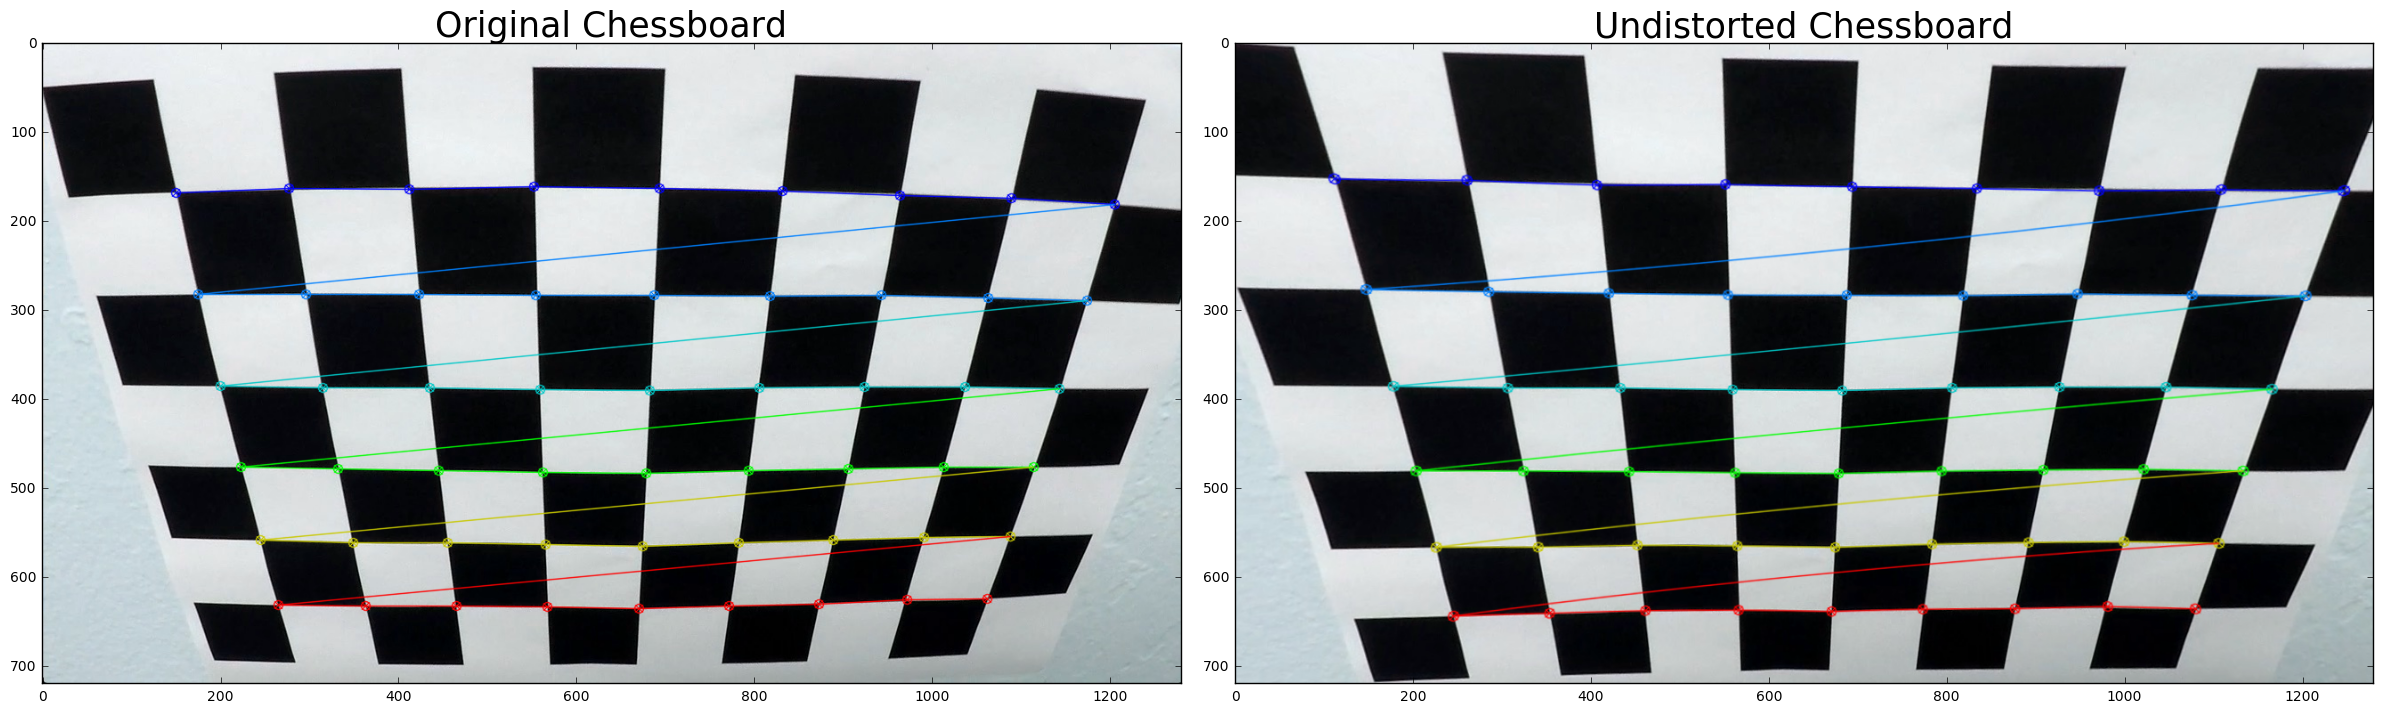

In [3]:
# Calibration parameters.
cshape = (9, 6)
path = 'camera_cal/'
mtx, dist = lane.calibration_parameters(path, cshape)

# Test calibration on some image.
filenames = os.listdir(path)
lane.test_calibration(path + filenames[11], cshape, mtx, dist)

Source points:
 [[  240.   720.]
 [  575.   460.]
 [  715.   460.]
 [ 1150.   720.]]
Destination points:
 [[  240.   720.]
 [  240.     0.]
 [ 1150.     0.]
 [ 1150.   720.]]
Perspective scaling: [ 0.044  0.01 ]


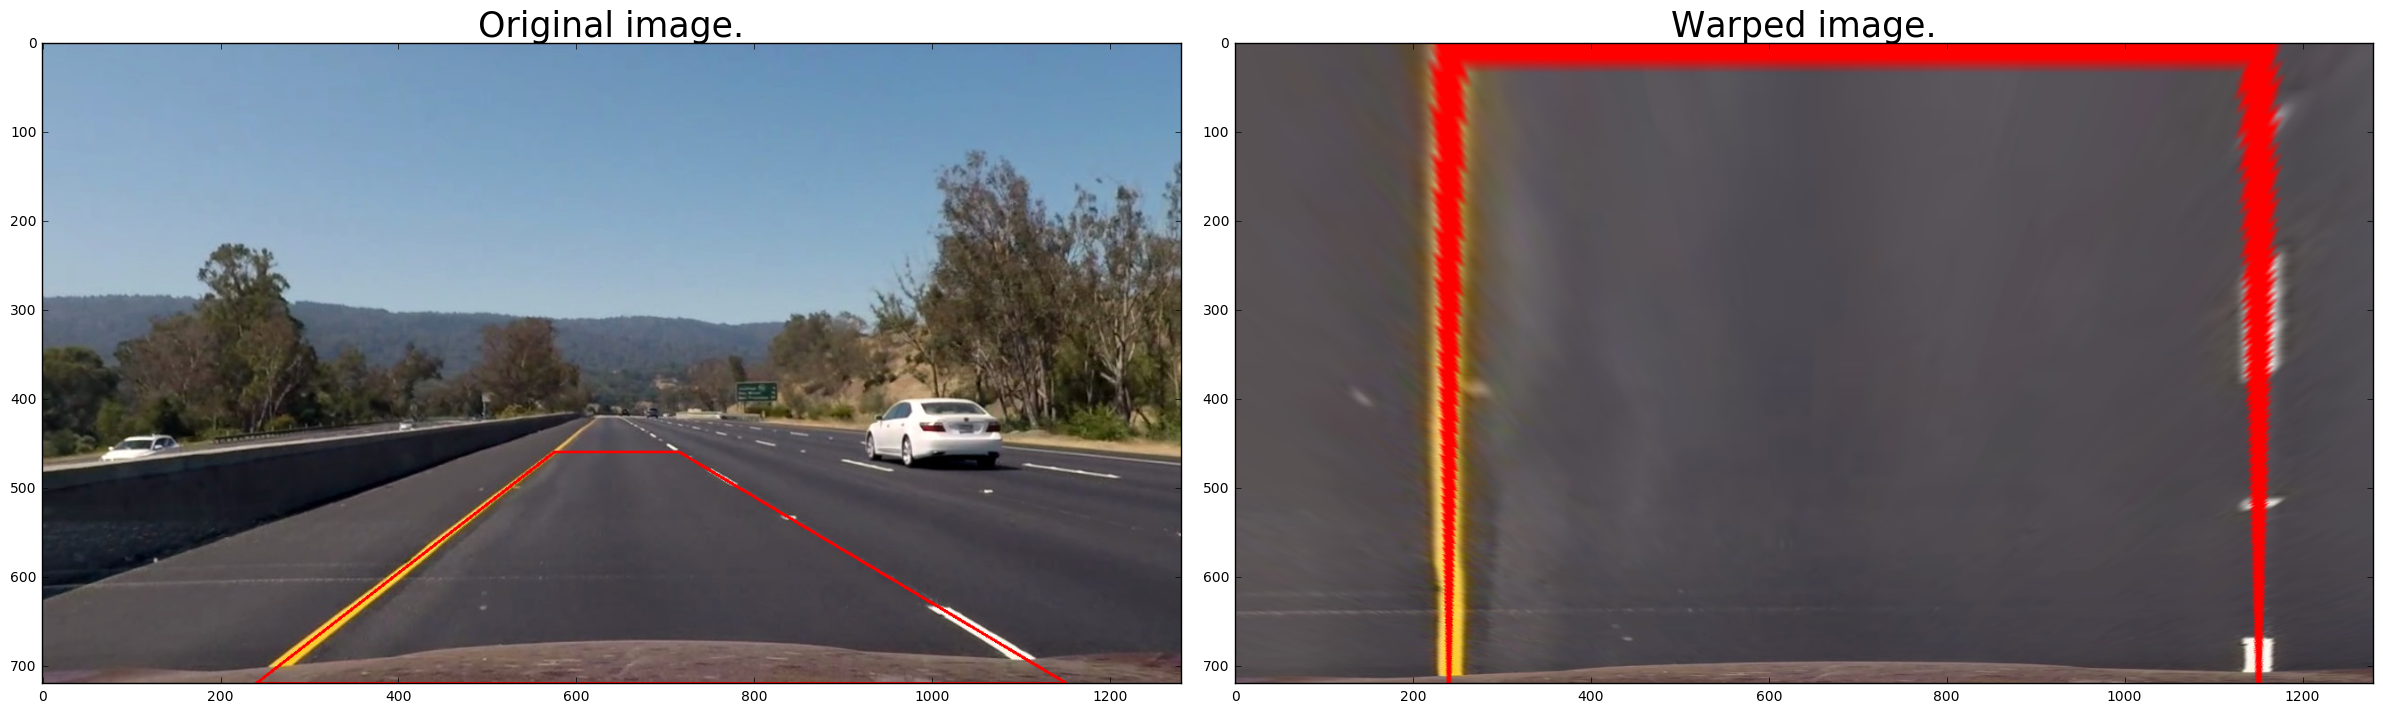

In [4]:
# Determine perspective transform.
fname = 'perspective/perspective.json'
src_points = lane.load_points(fname, 'src', dtype=np.float32)
dst_points = lane.load_points(fname, 'dst', dtype=np.float32)
perp_scaling = lane.load_points(fname, 'scaling', dtype=np.float32)
mtx_perp, mtx_perp_inv = lane.perspective_transform(src_points, dst_points)
print('Source points:\n', src_points)
print('Destination points:\n', dst_points)
print('Perspective scaling:', perp_scaling)

# Test the perspective transform.
fname = 'perspective/perspective.jpg'
img = lane.undistort_image(lane.load_image(fname), mtx, dist)
lane.test_perspective(img, src_points, mtx_perp)

In [5]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def gradient_magnitude(gray, sobel_kernel=3):
    """Compute mask based on gradient magnitude. Input image assumed
    to be two dimensional.
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Norm and rescaling (c.f. different kernel sizes)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255.
    gradmag = (gradmag / scale_factor)
    return gradmag

def gradient_x(gray, sobel_kernel=3):
    """Compute mask based on horizontal gradient. Input image assumed
    to be two dimensional.
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    gradmag = sobelx
    scale_factor = np.max(gradmag) / 255.
    gradmag = (gradmag / scale_factor)
    return gradmag

def gradient_y(gray, sobel_kernel=3):
    """Compute mask based on horizontal gradient. Input image assumed
    to be two dimensional.
    """
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = sobely
    scale_factor = np.max(gradmag) / 255.
    gradmag = (gradmag / scale_factor)
    return gradmag

def mask_local_crossing_x(gray, threshold=20, dilate_kernel=(2, 6), iterations=3):
    # Increasing mask.
    mask_neg = (gray < -threshold).astype(np.float32)
    mask_pos = (gray > threshold).astype(np.float32)
    
#     iterations=4
    mid=dilate_kernel[1] // 2
    # Dilate mask to the left.
    kernel = np.ones(dilate_kernel, np.uint8)
    kernel[:, 0:mid] = 0
    dmask_neg = cv2.dilate(mask_neg, kernel, iterations=iterations) > 0.
    # Dilate mask to the right.
    kernel = np.ones(dilate_kernel, np.uint8)
    kernel[:, mid:] = 0
    dmask_pos = cv2.dilate(mask_pos, kernel, iterations=iterations) > 0.
    dmask = (dmask_pos * dmask_neg).astype(np.uint8)
    
    # Eroding a bit
#     kernel = np.ones((1,2),np.uint8)
#     dmask = cv2.erode(dmask, kernel, iterations=5)
    return dmask
    

def mask_threshold(gray, threshold=(0, 255)):
    mask = np.zeros_like(gray)
    mask[(gray >= threshold[0]) & (gray <= threshold[1])] = 1
    return mask


def color_threshold(gray, threshold=(0, 255)):
    mask = np.zeros_like(gray)
    mask[(gray >= threshold[0]) & (gray <= threshold[1])] = 1
    return mask

In [6]:
def cvt_color_space(img, flag, sublines=10):
    cimg = np.zeros_like(img)
    height = img.shape[0] // sublines
    for i in range(sublines):
        beg = i * height
        end = (i+1) * height if i < sublines-1 else img.shape[0]
        cimg[beg:end, ...] = cv2.cvtColor(img[beg:end, ...], flag)
    return cimg
    

In [7]:
# Test images.
path = 'test_images/'
filenames = os.listdir(path)
print(filenames)

['signs_vehicles_xygrad.jpg', 'test (1).jpg', 'test (10).jpg', 'test (11).jpg', 'test (12).jpg', 'test (13).jpg', 'test (14).jpg', 'test (15).jpg', 'test (16).jpg', 'test (17).jpg', 'test (18).jpg', 'test (19).jpg', 'test (2).jpg', 'test (3).jpg', 'test (4).jpg', 'test (5).jpg', 'test (6).jpg', 'test (7).jpg', 'test (8).jpg', 'test (9).jpg', 'test1.jpg', 'test12.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


TEST on image: test_images/test (8).jpg (720, 1280, 3)
32.9260286458
27.0


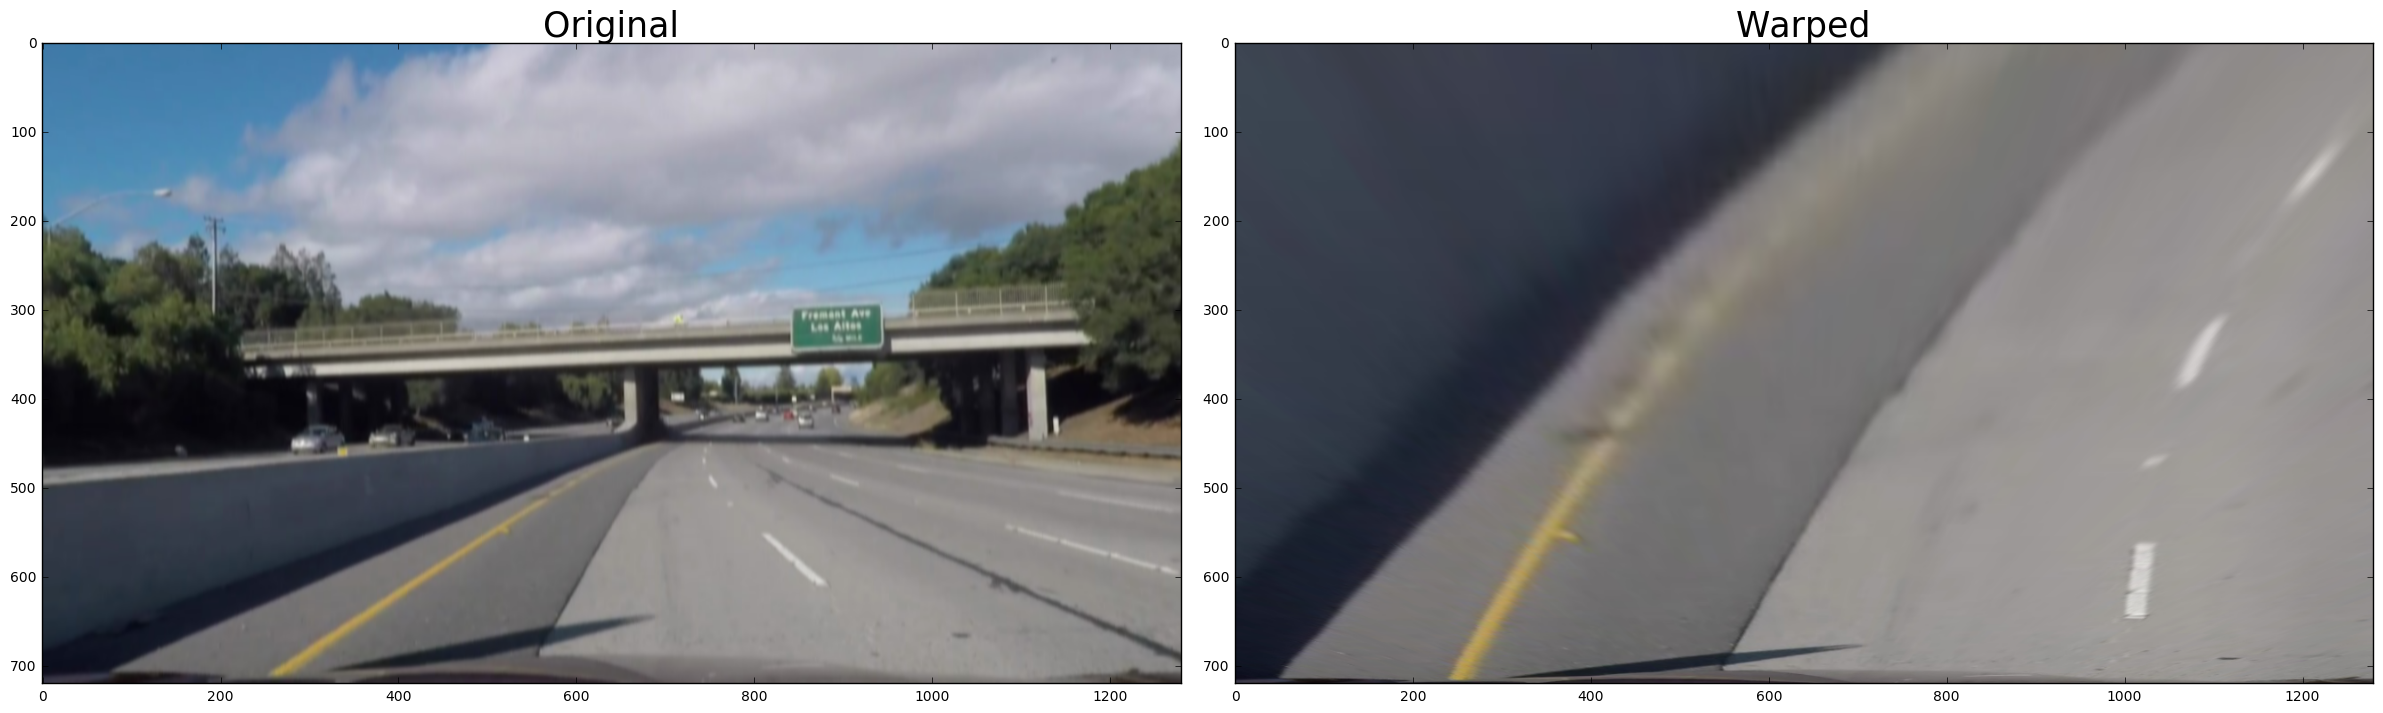

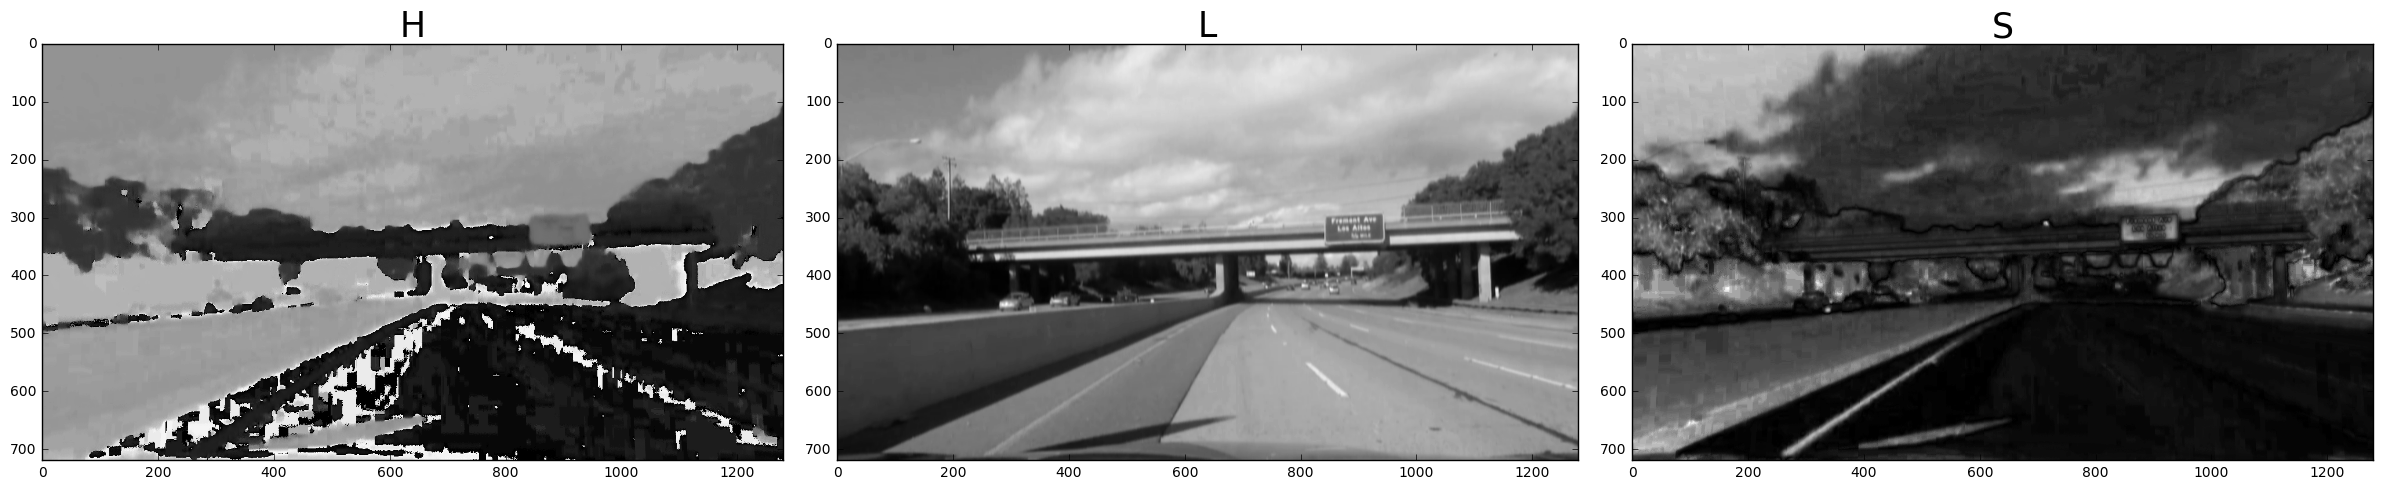

In [8]:
# Test on some image...
fname = path + os.listdir(path)[18]
img = lane.undistort_image(lane.load_image(fname), mtx, dist)
img = adjust_gamma(img, gamma=1.)
wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
print('TEST on image:', fname, img.shape)
img = cv2.GaussianBlur(img, (1, 11), 0)
    
# Color spaces...
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
# img_hsl = cvt_color_space(img, cv2.COLOR_RGB2Lab, 10)

# Plot the bouzin!
lane.plot_images((img, wimg), ('Original', 'Warped'), figsize=(24, 9))
lane.plot_images((img_hsl[:, : , 0], img_hsl[:, : , 1], img_hsl[:, : , 2]), ('H', 'L', 'S'), figsize=(24, 9))
# lane.plot_images((img_hsl[:, :]), ('H', 'L', 'S'), figsize=(24, 9))

print(np.mean(img_hsl[:, : , 2]))
print(np.median(img_hsl[:, : , 2]))

In [9]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def warped_masks(img, m_perp):
    """Generate a collection of masks for lines.
    Note: a collection can be useful to then compute weights.
    """
    wmasks = []
#     img = cv2.GaussianBlur(img, (1, 51), 0)
    
    # Grayscale and HSL.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Compute x gradients.
    skernel = 13
    sobel_dx = gradient_x(gray, sobel_kernel=skernel)
    s_sobel_dx = gradient_x(hsl[:, :, 2], sobel_kernel=skernel)
    # sobel_mag = gradient_magnitude(ungray, sobel_kernel=5)
    
    # Warped gradient fields.
#     wsobel_dx = cv2.warpPerspective(sobel_dx, m_perp, img_size, flags=cv2.INTER_LINEAR)
#     ws_sobel_dx = cv2.warpPerspective(s_sobel_dx, m_perp, img_size, flags=cv2.INTER_LINEAR)
    wsobel_dx = lane.warp_image(sobel_dx, m_perp, flags=cv2.INTER_LINEAR)
    ws_sobel_dx = lane.warp_image(s_sobel_dx, m_perp, flags=cv2.INTER_LINEAR)
    
    gammas = [0.3, 1., 3.]
    gammas = [1.]
    
    for g in gammas:
        img_gamma = adjust_gamma(img, gamma=g)
        
        # Warped images.
        wimg = lane.warp_image(img_gamma, mtx_perp, flags=cv2.INTER_LANCZOS4)
        wgray = cv2.cvtColor(wimg, cv2.COLOR_RGB2GRAY)
        whsl = cv2.cvtColor(wimg, cv2.COLOR_RGB2HLS)

        skernel = 13
        wsobel_dx = gradient_x(wgray, sobel_kernel=skernel)
        ws_sobel_dx = gradient_x(whsl[:, :, 2], sobel_kernel=skernel)

        # Construct warped masks
        mask = mask_local_crossing_x(wsobel_dx, threshold=15, dilate_kernel=(1, 6), iterations=4)
        wmasks.append(mask)
        mask = mask_local_crossing_x(ws_sobel_dx, threshold=25, dilate_kernel=(1, 6), iterations=4)
        wmasks.append(mask)

#     img_blur = gaussian_blur(gray, kernel_size=11)
#     edges = canny(img_blur, low_threshold=5, high_threshold=30)
#     wmasks.append(lane.warp_image(edges, m_perp, flags=cv2.INTER_LINEAR))
        
#     img_blur = gaussian_blur(hsl[:,:,2], kernel_size=11)
#     edges = canny(img_blur, low_threshold=10, high_threshold=70)
#     wmasks.append(lane.warp_image(edges, m_perp, flags=cv2.INTER_NEAREST))

    # masks.append(mask_threshold(sobel_mag, threshold=(50, 255)))
    # masks.append(mask_threshold(s_sobel_mag, threshold=(30, 255)))
    # masks.append(color_threshold(unhsl[:, :, 2], threshold=(10, 255)))
    # masks.append(color_threshold(unhsl[:, :, 2], threshold=(10, 255)))
    
    return wmasks



def default_left_right_masks(img, margin=0.1):
    """Default left and right masks used to find lanes: middle split with some additional margin.
    """
    shape = img.shape[0:2]
    llimit = int(shape[1] / 2 + shape[1] * margin)
    rlimit = int(shape[1] / 2 - shape[1] * margin)
    
    # Mask from meshgrid.
    xv, yv = np.mgrid[0:shape[0], 0:shape[1]]
    lmask = yv <= llimit
    rmask = yv >= rlimit
    
    return lmask, rmask


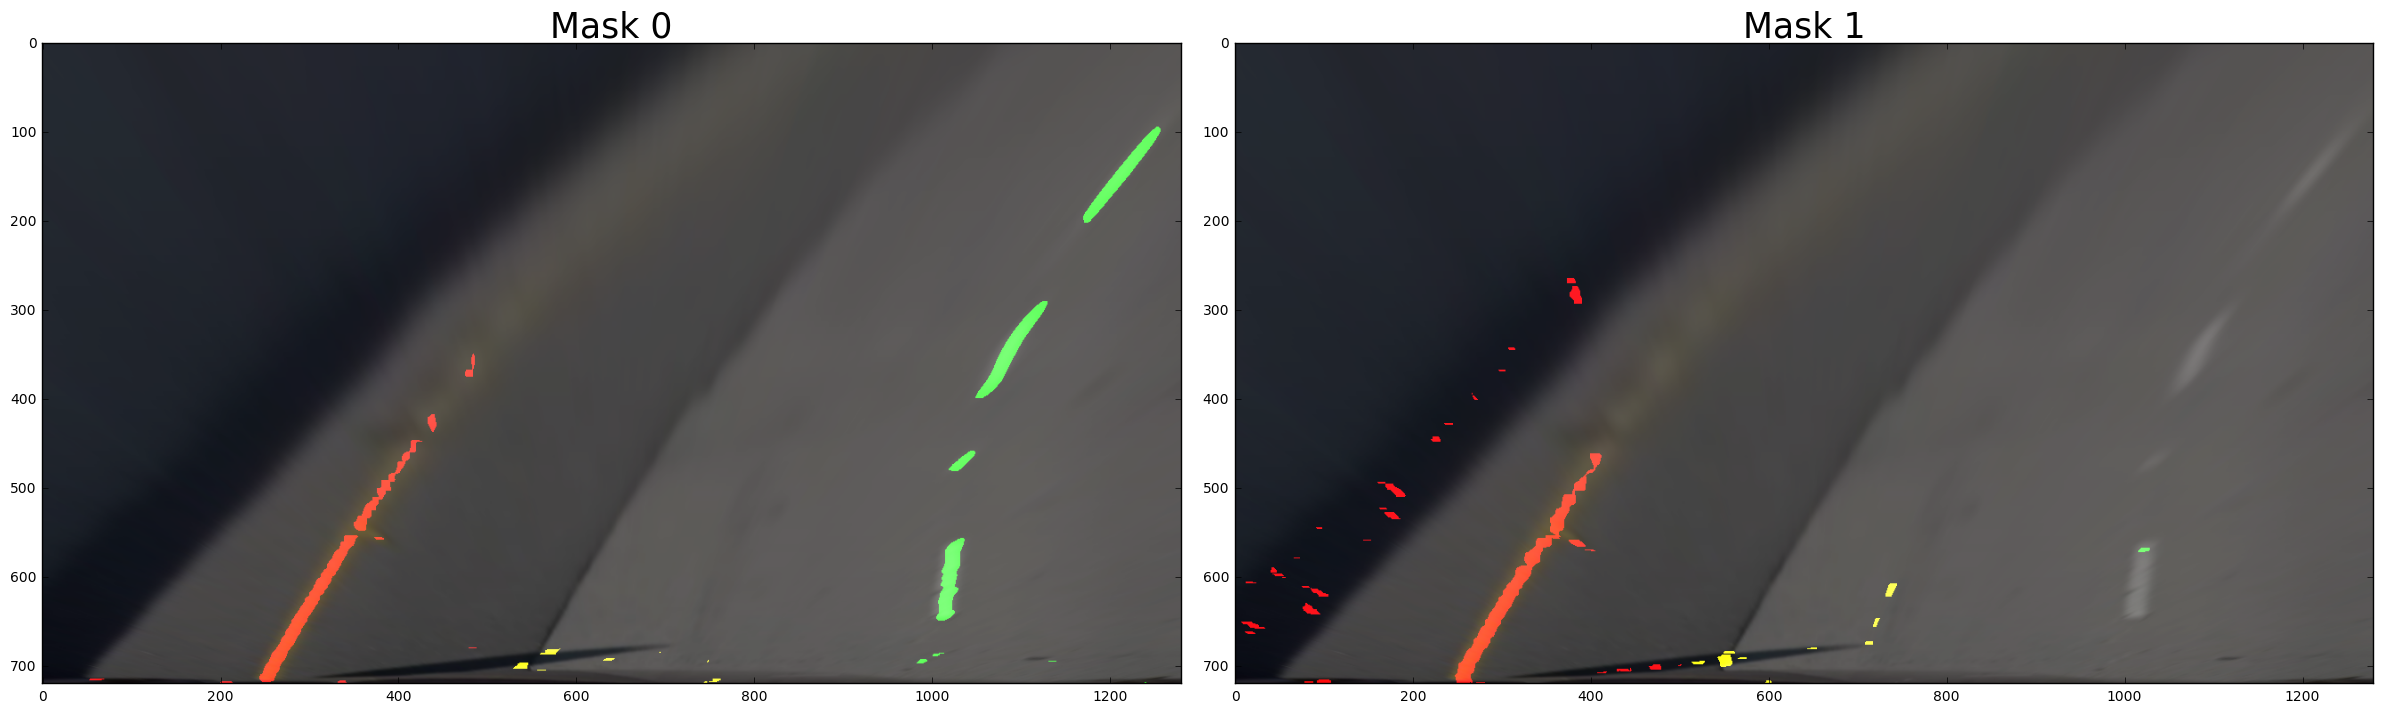

In [10]:
# Compute warped masks...
wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
wmasks = warped_masks(img, mtx_perp)
lmask, rmask = default_left_right_masks(img, margin=0.1)

# Masks to plot...
wimgs = []
titles = []
for i, wm in enumerate(wmasks):
    mimg = lane.draw_mask(wimg, wm * lmask, alpha=0.6, beta=1., gamma=0., color=[255, 0, 0])
    mimg = lane.draw_mask(mimg, wm * rmask, alpha=1, beta=1., gamma=0., color=[0, 255, 0])
    wimgs.append(mimg)
    titles.append('Mask %i' % i)

for i in range(len(wimgs) // 2):
    lane.plot_images(wimgs[2*i:2*i+2], titles[2*i:2*i+2], figsize=(24, 9))
#     lane.plot_images(wimgs[2:4], titles[2:4], figsize=(24, 9))
# lane.plot_images(wimgs[4:], titles[4:], figsize=(24, 9))


In [11]:
wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
wmasks = warped_masks(img, mtx_perp)
lmask, rmask = default_left_right_masks(img, margin=0.1)

FLOAT_DTYPES = np.float64

def fit_ransac(wmasks, add_mask):
    """Fit a Ransac linear regression to masks points.
    """
    x = np.zeros((0,))
    y = np.zeros((0,))
    for wm in wmasks:
        # Perspective trick: construct points in initial space.
        # Avoid giving too much weights to background parts.
        x0, y0 = np.where(wm * add_mask)
        x = np.append(x, x0)
        y = np.append(y, y0)
        
    # Construct big vector! Assume order-2 model.
    X = np.zeros((len(x), 3), dtype=np.float32)
    X[:, 0] = 1.
    X[:, 1] = x
    X[:, 2] = x**2
   
    # Fit regression.
    res_threshold = 10
    max_trials = 2000
    mransac = linear_model.RANSACRegressor(linear_model.LinearRegression(), 
                                           residual_threshold=res_threshold, max_trials=max_trials)
    mransac.fit(X, y)
    
    return mransac, x, y


def warped_lane_mask(wimg, mransac_left, mransac_right):
    """Generate the lane mask based on left and right regression.
    """
    shape = wimg.shape[0:2]
    # Lines predictions.
    X = np.vstack((np.ones(shape[0], ), np.arange(0, shape[0]), np.arange(0, shape[0])**2)).T
    y_left = mransac_left.predict(X)
    y_right = mransac_right.predict(X)

    # Create an image to draw the lines on
    warp_zero = np.zeros(shape, np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([y_left, X[:, 1]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([y_right, X[:, 1]])))])
    pts = np.hstack((pts_left, pts_right))
    
    pts = np.array([pts], dtype=np.int64)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, pts, (0,255, 0))
    return color_warp

mransac_left, x_left, y_left = fit_ransac(wmasks, lmask)
mransac_right, x_right, y_right = fit_ransac(wmasks, rmask)

# Inlier / Outlier masks
inlier_mask_left = mransac_left.inlier_mask_
outlier_mask_left = np.logical_not(inlier_mask_left)
inlier_mask_right = mransac_right.inlier_mask_
outlier_mask_right = np.logical_not(inlier_mask_right)

# New prediction!
line_X_left = np.vstack((np.ones(720, ), np.arange(0, 720), np.arange(0, 720)**2)).T
line_y_left = mransac_left.predict(line_X_left)
line_y_right = mransac_right.predict(line_X_left)

# print(mransac_left.predict([0.0, 0.0, 0.0]))

wmask_lane = warped_lane_mask(wimg, mransac_left, mransac_right)

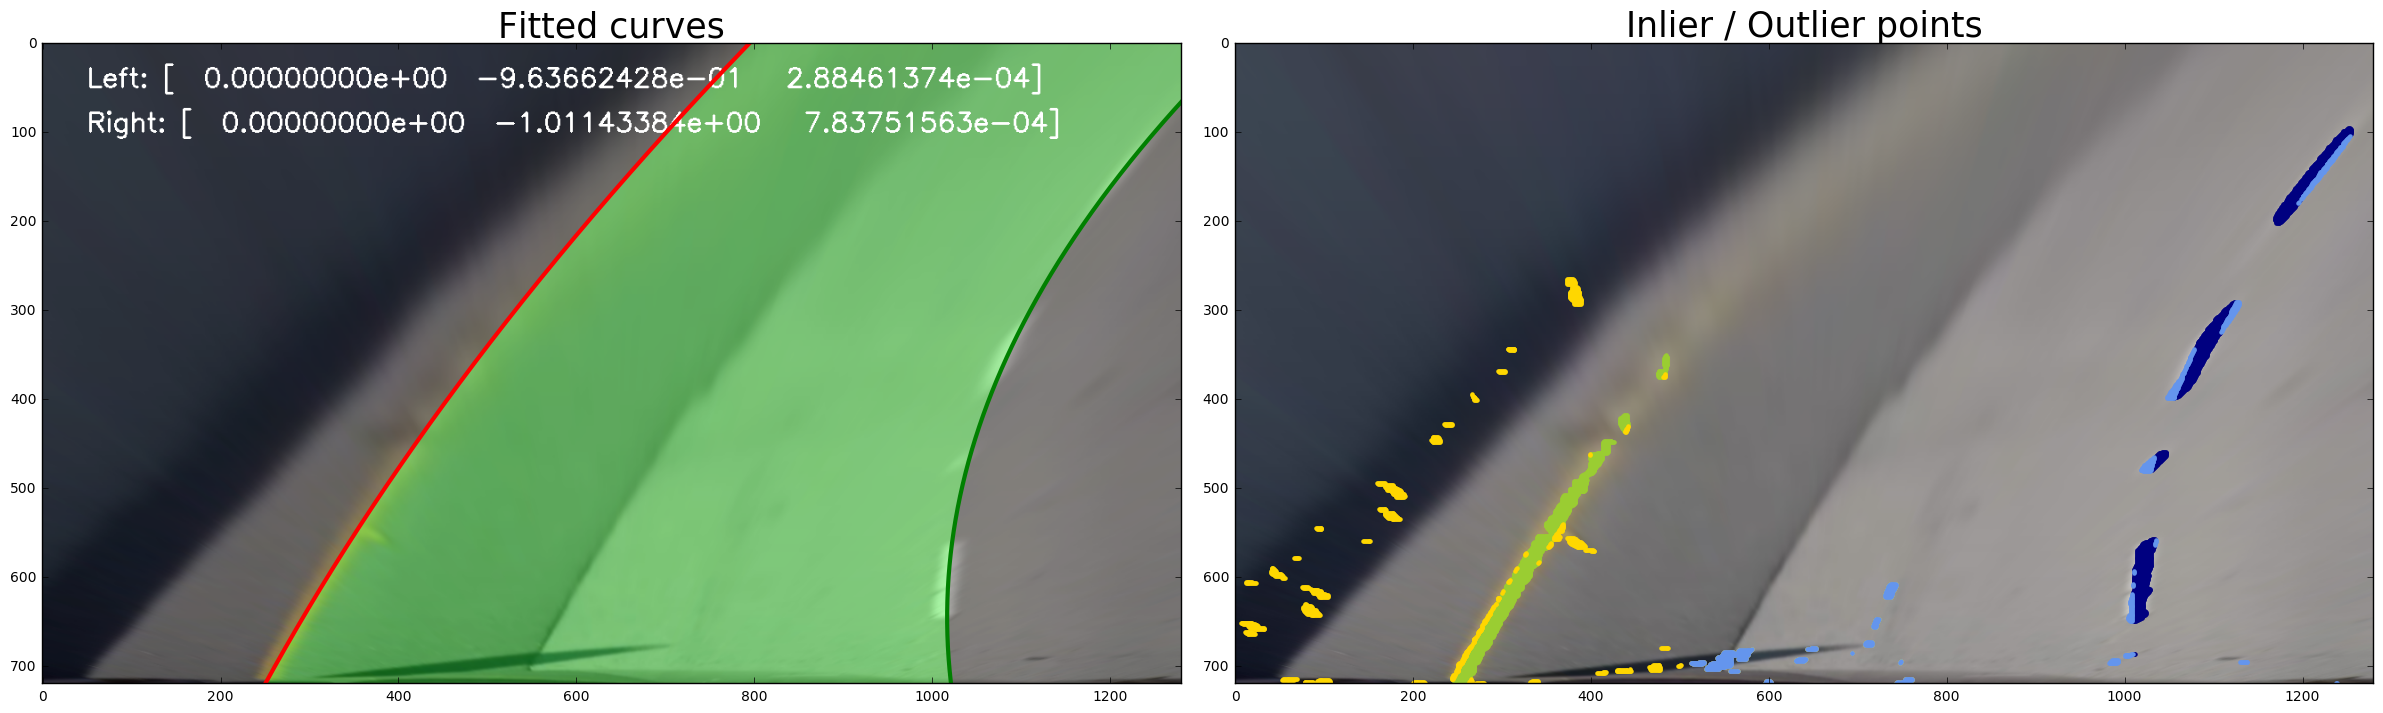

In [12]:
# Plot fitted curves
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(line_y_left, line_X_left[:, 1],  color='red', linestyle='-', linewidth=3)
ax1.plot(line_y_right, line_X_left[:, 1],  color='green', linestyle='-', linewidth=3)

wm_img = cv2.addWeighted(wimg, 0.8, wmask_lane, 0.3, 0.)
cv2.putText(wm_img, "Left: %s" % mransac_left.estimator_.coef_, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(wm_img, "Right: %s" % mransac_right.estimator_.coef_, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
ax1.imshow(wm_img)
ax1.set_title('Fitted curves', fontsize=25)

# Scatter points: inlier and outlier.
plt.scatter(y_left[inlier_mask_left], x_left[inlier_mask_left], color='yellowgreen', marker='.')
plt.scatter(y_left[outlier_mask_left], x_left[outlier_mask_left], color='gold', marker='.')
plt.scatter(y_right[inlier_mask_right], x_right[inlier_mask_right], color='navy', marker='.', linewidth=1)
plt.scatter(y_right[outlier_mask_right], x_right[outlier_mask_right], color='cornflowerblue', marker='.', linewidth=1)
ax2.imshow(wimg)
ax2.set_title('Inlier / Outlier points', fontsize=25)
plt.show()

In [13]:
FLOAT_DTYPES = np.float64

# Warped image and masks
wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
wmasks = warped_masks(img, mtx_perp)
lmask, rmask = default_left_right_masks(img, margin=0.1)

# Masks points.
X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True)
X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True)

# Model validation bounds.
valid_diffs = np.zeros((3, 2), dtype=X1.dtype)
valid_bounds = np.zeros((3, 2, 2), dtype=X1.dtype)

valid_diffs[0, 0] = 0.6
valid_diffs[0, 1] = 0.8
valid_diffs[1, 1] = 0.3
valid_diffs[2, 1] = 0.2

# Fit regression.
res_threshold = 0.01
n_prefits = 10000
max_trials = 500000
lanes_ransac = DLanesRANSACRegressor(residual_threshold=res_threshold, 
                                     is_valid_diffs=valid_diffs, 
                                     is_valid_bounds=valid_bounds,
                                     n_prefits=n_prefits,
                                     max_trials=max_trials)
lanes_ransac.fit(X1, y1, X2, y2)



DLanesRANSACRegressor(is_valid_bounds=array([[[ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.]]]),
           is_valid_diffs=array([[ 0.6,  0.8],
       [ 0. ,  0.3],
       [ 0. ,  0.2]]),
           max_trials=500000, n_prefits=10000, random_state=None,
           residual_threshold=0.01, stop_n_inliers=inf,
           stop_probability=0.99, stop_score=inf)

In [14]:
# %prun -s cumulative lanes_ransac.fit(X1, y1, X2, y2)

In [15]:
X_lane, y1_lane, y2_lane = lane.predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
x_lane = X_lane[:, 1]

X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=False, normalise=False)
X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=False, normalise=False)
x1 = X1[:, 1]
x2 = X2[:, 1]

lane_wmask = lane.lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)

# Inlier / Outlier masks
inlier_mask1 = lanes_ransac.inlier_mask1_
outlier_mask1 = np.logical_not(inlier_mask1)
inlier_mask2 = lanes_ransac.inlier_mask2_
outlier_mask2 = np.logical_not(inlier_mask2)


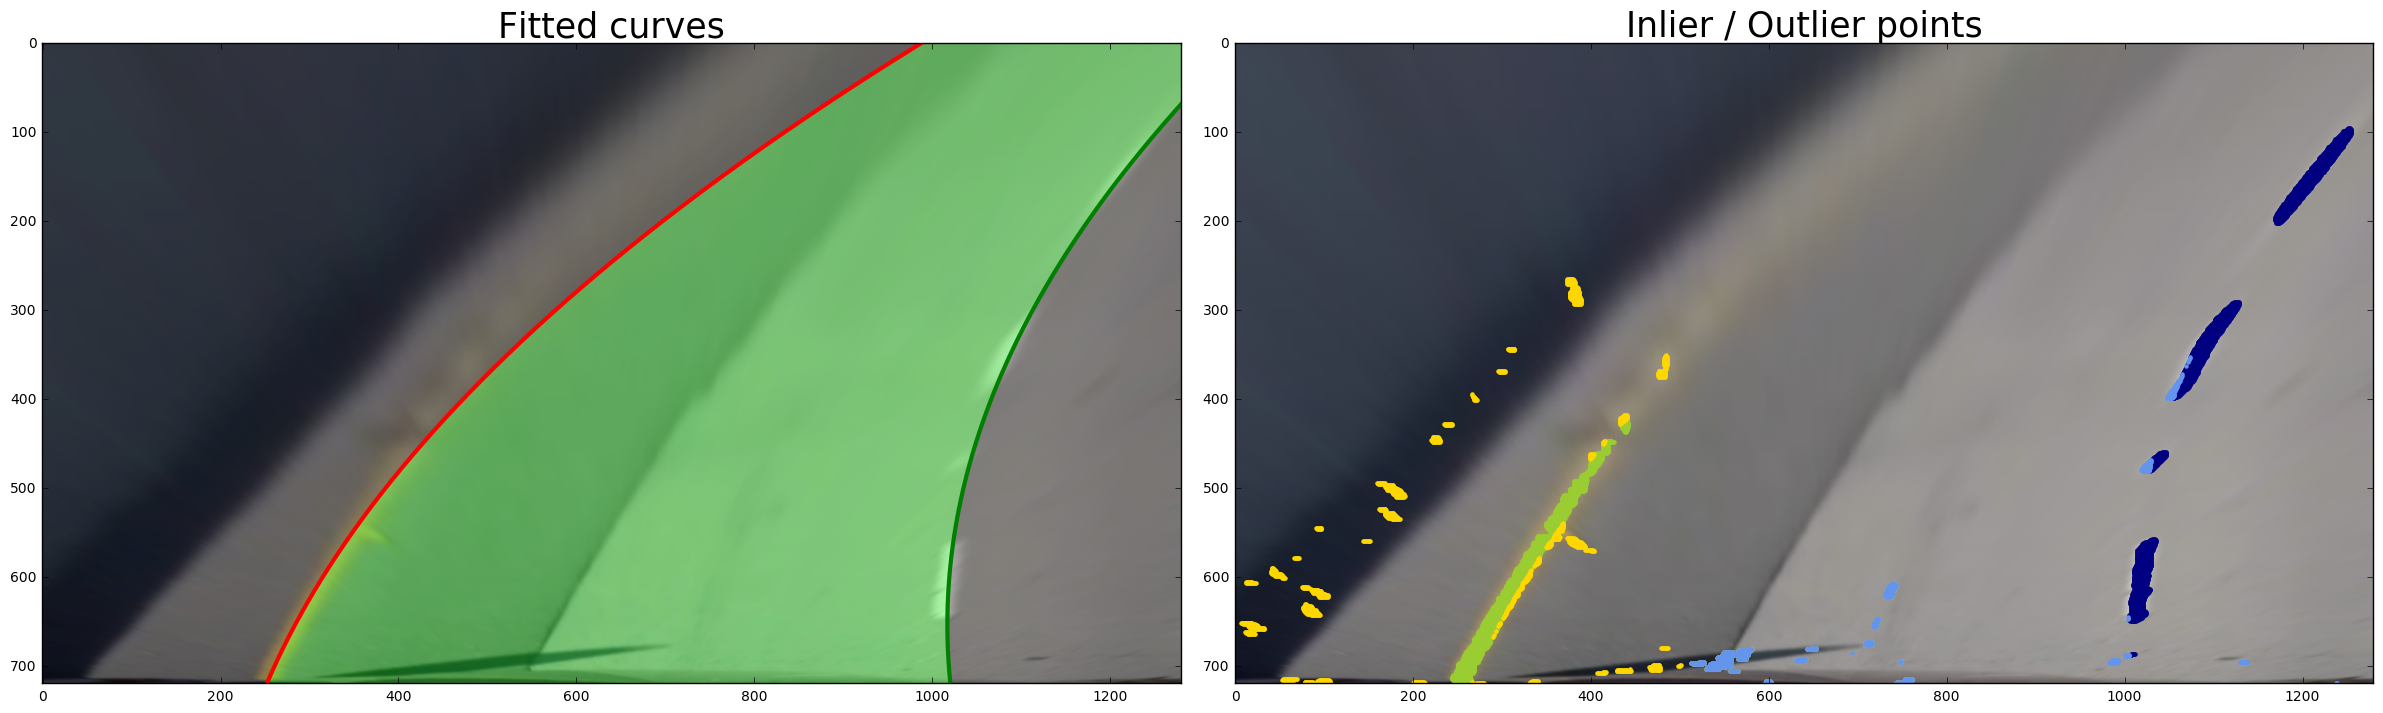

In [16]:
# Plot fitted curves
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(y1_lane, x_lane,  color='red', linestyle='-', linewidth=3)
ax1.plot(y2_lane, x_lane,  color='green', linestyle='-', linewidth=3)
wm_img = cv2.addWeighted(wimg, 0.8, lane_wmask, 0.3, 0.)
# cv2.putText(wm_img, "Left: %s" % mransac_left.estimator_.coef_, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
# cv2.putText(wm_img, "Right: %s" % mransac_right.estimator_.coef_, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
ax1.imshow(wm_img)
ax1.set_title('Fitted curves', fontsize=25)

# Scatter points: inlier and outlier.
plt.scatter(y1[inlier_mask1], x1[inlier_mask1], color='yellowgreen', marker='.')
plt.scatter(y1[outlier_mask1], x1[outlier_mask1], color='gold', marker='.')
plt.scatter(y2[inlier_mask2], x2[inlier_mask2], color='navy', marker='.')
plt.scatter(y2[outlier_mask2], x2[outlier_mask2], color='cornflowerblue', marker='.')
ax2.imshow(wimg)
ax2.set_title('Inlier / Outlier points', fontsize=25)
plt.show()

1.61975717953 2.21628978363 [[ -2.41018767e-01  -5.30665431e-02  -1.15811319e-03  -1.28284935e-04
    2.67026162e-02]]


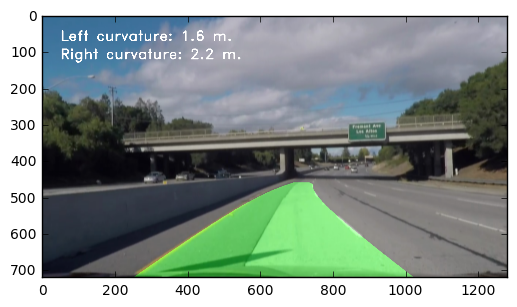

In [17]:
# Unwarp everything!
mask_lane = lane.warp_image(lane_wmask, mtx_perp_inv, flags=cv2.INTER_NEAREST)
mask_img = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)

# Add curvature information.
# curv_left = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
# curv_right = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))
dist_lanes = lanes_ransac.w2_[0] - lanes_ransac.w1_[0]
curv_left = lane.lane_curvature(lanes_ransac.w1_)
curv_right = lane.lane_curvature(lanes_ransac.w2_) + dist_lanes

cv2.putText(mask_img, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
cv2.putText(mask_img, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

print(curv_left, curv_right, dist)
plt.imshow(mask_img)

In [18]:
FLOAT_DTYPES = np.float64

# Warped image and masks
wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
wmasks = warped_masks(img, mtx_perp)
lmask, rmask = default_left_right_masks(img, margin=0.1)

# Masks points.
X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True)
X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True)

# Model validation bounds.
left_right_bounds = np.zeros((1, 3, 2), dtype=X1.dtype)
left_right_bounds[0, 0, 0] = 0.6
left_right_bounds[0, 0, 1] = 0.8
left_right_bounds[0, 1, 1] = 0.3
left_right_bounds[0, 2, 1] = 0.25
valid_bounds = np.zeros((0, 3, 2), dtype=X1.dtype)

# Fit regression.
res_threshold = 0.01
n_prefits = 500
max_trials = 50000
lanes_ransac = SLanesRANSACRegressor(residual_threshold=res_threshold, 
                                     n_prefits=n_prefits,
                                     max_trials=max_trials)
lanes_ransac.fit(X1, y1, X2, y2, left_right_bounds)

SLanesRANSACRegressor(is_valid_bounds_left=array([], shape=(0, 3, 2), dtype=float64),
           is_valid_bounds_right=array([], shape=(0, 3, 2), dtype=float64),
           max_trials=50000, n_prefits=500, random_state=None,
           residual_threshold=0.01, stop_n_inliers=inf,
           stop_probability=0.99, stop_score=inf,
           w_refs_left=array([], shape=(0, 3), dtype=float64),
           w_refs_right=array([], shape=(0, 3), dtype=float64))

In [19]:
# %prun -s cumulative lanes_ransac.fit(X1, y1, X2, y2, left_right_bounds)

In [20]:
X_lane, y1_lane, y2_lane = lane.predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
x_lane = X_lane[:, 1]

X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=False, normalise=False)
X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=False, normalise=False)
x1 = X1[:, 1]
x2 = X2[:, 1]

lane_wmask = lane.lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)

# Inlier / Outlier masks
inlier_mask1 = lanes_ransac.inlier_mask1_
outlier_mask1 = np.logical_not(inlier_mask1)
inlier_mask2 = lanes_ransac.inlier_mask2_
outlier_mask2 = np.logical_not(inlier_mask2)


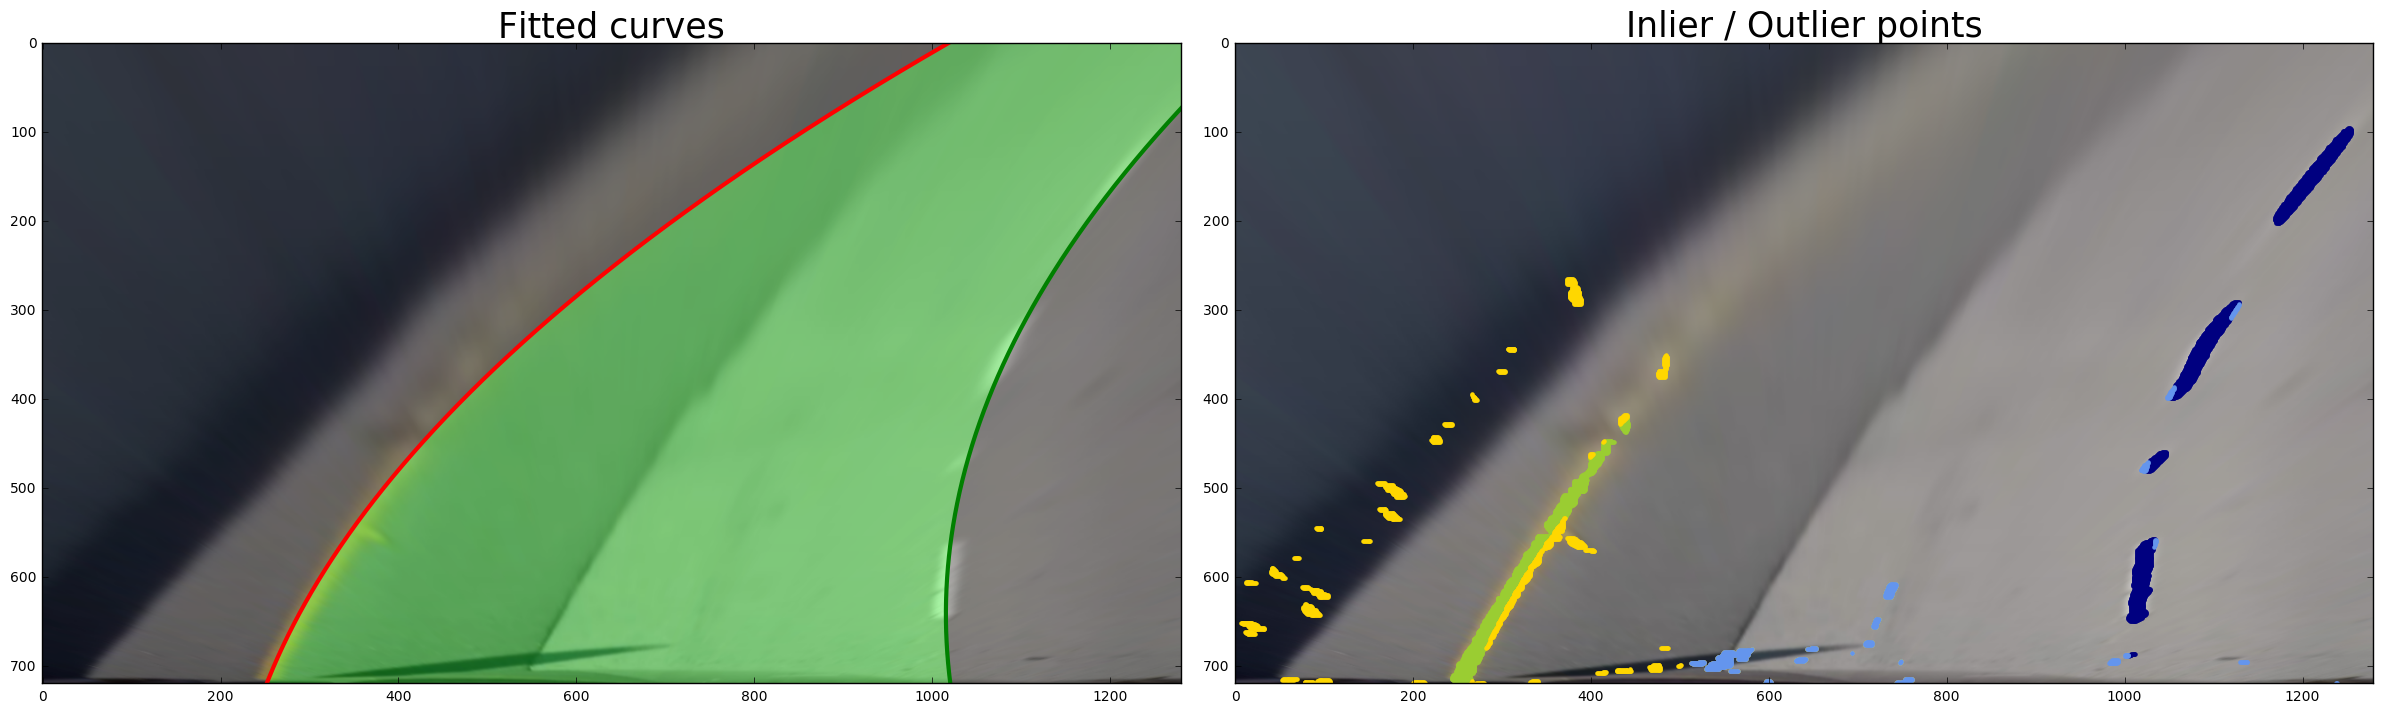

In [21]:
# Plot fitted curves
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(y1_lane, x_lane,  color='red', linestyle='-', linewidth=3)
ax1.plot(y2_lane, x_lane,  color='green', linestyle='-', linewidth=3)
wm_img = cv2.addWeighted(wimg, 0.8, lane_wmask, 0.3, 0.)
# cv2.putText(wm_img, "Left: %s" % mransac_left.estimator_.coef_, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
# cv2.putText(wm_img, "Right: %s" % mransac_right.estimator_.coef_, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
ax1.imshow(wm_img)
ax1.set_title('Fitted curves', fontsize=25)

# Scatter points: inlier and outlier.
plt.scatter(y1[inlier_mask1], x1[inlier_mask1], color='yellowgreen', marker='.')
plt.scatter(y1[outlier_mask1], x1[outlier_mask1], color='gold', marker='.')
plt.scatter(y2[inlier_mask2], x2[inlier_mask2], color='navy', marker='.')
plt.scatter(y2[outlier_mask2], x2[outlier_mask2], color='cornflowerblue', marker='.')
ax2.imshow(wimg)
ax2.set_title('Inlier / Outlier points', fontsize=25)
plt.show()

1.42359933233 2.12148199837 [[ -2.41018767e-01  -5.30665431e-02  -1.15811319e-03  -1.28284935e-04
    2.67026162e-02]]


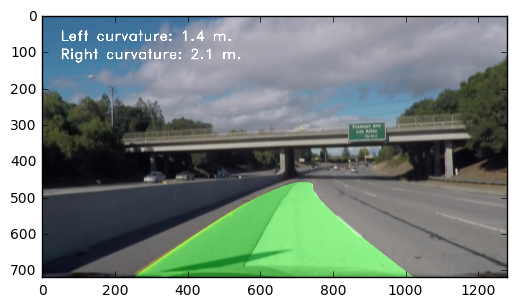

In [22]:
# Unwarp everything!
mask_lane = lane.warp_image(lane_wmask, mtx_perp_inv, flags=cv2.INTER_NEAREST)
mask_img = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)

# Add curvature information.
# curv_left = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
# curv_right = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))
dist_lanes = lanes_ransac.w2_[0] - lanes_ransac.w1_[0]
curv_left = lane.lane_curvature(lanes_ransac.w1_)
curv_right = lane.lane_curvature(lanes_ransac.w2_) + dist_lanes

cv2.putText(mask_img, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
cv2.putText(mask_img, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

print(curv_left, curv_right, dist)
plt.imshow(mask_img)

In [23]:
PleaseStopHere;

NameError: name 'PleaseStopHere' is not defined

In [ ]:
def process_image(path, fname):
    path_save = 'debug/'
    img_name = fname[:-4]
    img = lane.load_image(path + fname)
    img = lane.undistort_image(img, mtx, dist)
    wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
    
    # Warped image and masks
    wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
    wmasks = warped_masks(img, mtx_perp)
    lmask, rmask = default_left_right_masks(img, margin=0.1)
    
    # DEBUG save.
    masked_img = lane.draw_mask(wimg, wmasks[0] * lmask, alpha=0.5, beta=1., gamma=0., color=[255, 0, 0])
    masked_img = lane.draw_mask(masked_img, wmasks[0] * rmask, alpha=1, beta=1., gamma=0., color=[0, 255, 0])
    mpimg.imsave(path_save+img_name+'_wmask0.jpg', masked_img)
    masked_img = lane.draw_mask(wimg, wmasks[1] * lmask, alpha=0.5, beta=1., gamma=0., color=[255, 0, 0])
    masked_img = lane.draw_mask(masked_img, wmasks[1] * rmask, alpha=1, beta=1., gamma=0., color=[0, 255, 0])
    mpimg.imsave(path_save+img_name+'_wmask1.jpg', masked_img)

    # Masks points.
    X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True)
    X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True)

#     # Model validation bounds.
#     valid_diffs = np.zeros((3, 2), dtype=X1.dtype)
#     valid_bounds = np.zeros((3, 2, 2), dtype=X1.dtype)

#     valid_diffs[0, 0] = 0.6
#     valid_diffs[0, 1] = 0.8
#     valid_diffs[1, 1] = 0.25
#     valid_diffs[2, 1] = 0.2

    # Fit regression.
#     res_threshold = 0.008
#     n_prefits = 5000
#     max_trials = 500000
#     lanes_ransac = LanesRANSACRegressor(residual_threshold=res_threshold, 
#                                         is_valid_diffs=valid_diffs, 
#                                         is_valid_bounds=valid_bounds,
#                                         n_prefits=n_prefits,
#                                         max_trials=max_trials)
#     lanes_ransac.fit(X1, y1, X2, y2)
    
    # Model validation bounds.
    left_right_bounds = np.zeros((1, 3, 2), dtype=X1.dtype)
    left_right_bounds[0, 0, 0] = 0.6
    left_right_bounds[0, 0, 1] = 0.8
    left_right_bounds[0, 1, 1] = 0.3
    left_right_bounds[0, 2, 1] = 0.2
    valid_bounds = np.zeros((0, 3, 2), dtype=X1.dtype)

    # Fit regression.
    res_threshold = 0.01
    n_prefits = 5000
    max_trials = 50000
    lanes_ransac = SLanesRANSACRegressor(residual_threshold=res_threshold, 
                                         n_prefits=n_prefits,
                                         max_trials=max_trials)
    lanes_ransac.fit(X1, y1, X2, y2, left_right_bounds)
    
    # Lane mask.
    X_lane, y1_lane, y2_lane = lane.predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
    x_lane = X_lane[:, 1]
    wmask_lane = lane.lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)
    wimg_lane = cv2.addWeighted(wimg, 0.9, wmask_lane, 0.4, 0.)
    
    # Unwarp everything!
    mask_lane = lane.warp_image(wmask_lane, mtx_perp_inv, flags=cv2.INTER_NEAREST)
    img_lane = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)

    # Add curvature information.
    curv_left = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
    curv_right = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))
    cv2.putText(img_lane, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

    # Save images.
    mpimg.imsave(path_save+img_name+'_wlane.jpg', wimg_lane)
    mpimg.imsave(path_save+img_name+'_lane.jpg', img_lane)
    


In [ ]:
# Full pipeline on test images.
path = 'test_images/'
# path = 'test_images_kyle/'
filenames = os.listdir(path)
for fname in filenames:
    print('Processing image: ', fname)
    process_image(path, fname)
    


In [ ]:
fname = filenames[0]
%prun -s cumulative process_image(path, fname)

In [24]:
class LanesFit():
    def __init__(self):
        # Interpolation coefficients.
        self.w_left = np.zeros((3,), dtype=np.float32)
        self.w_right = np.zeros((3,), dtype=np.float32)
        # Fitting score.
        self.fit_score_left = 0.0
        self.fit_score_right = 0.0
        
        # Scaling and original shape.
        self.shape = (1, 1)
        self.scaling = (1., 1.)
        # Radius of curvature, in w units.
        self.radius = 0.0
        self.line_base_pos = 0.0
        
    def init_from_regressor(self, regr):
        self.w_left = regr.w1_
        self.w_right = regr.w2_
        self.fit_score_left = float(np.sum(regr.inlier_mask1_)) / regr.inlier_mask1_.size
        self.fit_score_right = float(np.sum(regr.inlier_mask2_)) / regr.inlier_mask2_.size
        
    def translate_coefficients(self, delta):
        """Translate lanes while keeping same curvature center.
        """
        w_left = self.w_left
        w1 = np.copy(self.w_left)
        w1[0] = delta + w_left[0]
        w1[1] = w_left[1]
        w1[2] = w_left[2] * (1 + w_left[1]**2)**1.5 / ((1 + w_left[1]**2)**1.5 + 2*delta*w_left[2])
        
        w_right = self.w_right
        w2 = np.copy(self.w_right)
        w2[0] = delta + w_right[0]
        w2[1] = w_right[1]
        w2[2] = w_right[2] * (1 + w_right[1]**2)**1.5 / ((1 + w_right[1]**2)**1.5 + 2*delta*w_right[2])
        return w1, w2
        
    def masks(self, delta):
        delta = np.abs(delta)
        # Meshgrid
        xv, yv = np.mgrid[0:self.shape[0], 0:self.shape[1]]
        xv = xv / float(self.scaling[0])
        yv = yv / float(self.scaling[1])
        
        # Left part of the masks.
        w1, w2 = self.translate_coefficients(delta)
        y1 = w1[0] + w1[1] * xv + w1[2] * xv**2
        y2 = w2[0] + w2[1] * xv + w2[2] * xv**2
        lmask = yv <= y1
        rmask = yv <= y2
        
        # Right part of the masks.
        w1, w2 = self.translate_coefficients(-delta)
        y1 = w1[0] + w1[1] * xv + w1[2] * xv**2
        y2 = w2[0] + w2[1] * xv + w2[2] * xv**2
        lmask = np.logical_and(lmask, yv >= y1)
        rmask = np.logical_and(rmask, yv >= y2)
        
        return lmask, rmask
        

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

def process_image_frame(img_orig):
    lanes_past = process_image_frame.lanes_past
    
    img = lane.undistort_image(img_orig, mtx, dist)
    wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
    
    # Warped image and masks
    wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
    wmasks = warped_masks(img, mtx_perp)
    
    # Masks...
    if len(lanes_past) > 0:
        delta = 0.1
        lmask, rmask = lanes_past[-1].masks(delta)
    else:
        lmask, rmask = default_left_right_masks(img, margin=0.1)
    
    # Masks points.
    X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True)
    X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True)

#     # Model validation bounds.
#     valid_diffs = np.zeros((3, 2), dtype=X1.dtype)
#     valid_bounds = np.zeros((3, 2, 2), dtype=X1.dtype)

#     valid_diffs[0, 0] = 0.6
#     valid_diffs[0, 1] = 0.8
#     valid_diffs[1, 1] = 0.4
#     valid_diffs[2, 1] = 0.3

#     # Fit regression.
#     res_threshold = 0.007
#     n_prefits = 1000
#     max_trials = 500000
#     lanes_ransac = LanesRANSACRegressor(residual_threshold=res_threshold, 
#                                         is_valid_diffs=valid_diffs, 
#                                         is_valid_bounds=valid_bounds,
#                                         n_prefits=n_prefits,
#                                         max_trials=max_trials)
#     lanes_ransac.fit(X1, y1, X2, y2)

    # Model validation bounds.
    left_right_bounds = np.zeros((1, 3, 2), dtype=X1.dtype)
    left_right_bounds[0, 0, 0] = 0.6
    left_right_bounds[0, 0, 1] = 0.8
    left_right_bounds[0, 1, 1] = 0.3
    left_right_bounds[0, 2, 1] = 0.2
    valid_bounds = np.zeros((0, 3, 2), dtype=X1.dtype)

    # Fit regression.
    res_threshold = 0.01
    n_prefits = 5000
    max_trials = 500000
    lanes_ransac = SLanesRANSACRegressor(residual_threshold=res_threshold, 
                                         n_prefits=n_prefits,
                                         max_trials=max_trials)
    lanes_ransac.fit(X1, y1, X2, y2, left_right_bounds)
    
    # Save lanes fit.
    lanes_fit = LanesFit()
    lanes_fit.init_from_regressor(lanes_ransac)
    lanes_fit.shape = wimg.shape
    lanes_fit.scaling = wimg.shape
    
    lanes_past.append(lanes_fit)
    if len(lanes_past) > 0:
        lanes_past.pop(0)
    process_image_frame.lanes_past = lanes_past
    
    # Lane mask.
    X_lane, y1_lane, y2_lane = lane.predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
    x_lane = X_lane[:, 1]
    wmask_lane = lane.lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)
    # Unwarp everything!
    mask_lane = lane.warp_image(wmask_lane, mtx_perp_inv, flags=cv2.INTER_NEAREST)
    img_lane = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)
    # Add curvature information.
    curv_left = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
    curv_right = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))
    cv2.putText(img_lane, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

    return img_lane
    


In [ ]:
process_image_frame.lanes_past = []

white_output = 'project_video_lane.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image_frame)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_lane.mp4
[MoviePy] Writing video project_video_lane.mp4


 13%|██████████▋                                                                    | 170/1261 [02:32<14:48,  1.23it/s]  0%|                                                                                 | 1/1261 [00:00<18:29,  1.14it/s]

In [ ]:
process_image_frame.lanes_past = []

white_output = 'challenge_video_lane.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image_frame)
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
process_image_frame.lanes_past = []

white_output = 'harder_challenge_video_lane.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image_frame)
%time white_clip.write_videofile(white_output, audio=False)